# Stock Price Prediction Model

This report shows statistical analysis and machine learning models built to predict future stock prices using price and news data.

## 1. Introduction

History has shown that the stock market as well as economy moves repeatedly in cycles over and over. Quantitative trading has been developed to help firms build mathematical models based on expert understanding of fundamental market relationships. It enables to steer the trading system in real time and let the model learn by itself and finally execute disciplined predictive models.

The purpose of quantitative trading is to help investors decide to long/short their financial assets by estimating the future given historical infomation. For example, when surrounded by all the euphoria of a bull market, investors are inclined to feel confident and take more risks to have high returns on their assets. Thus, it can be a good strategy to revise trading strategies via forecasting the future relying on mathematics.

There are two types of data used; Price data & News data. Note that they are available to download free with some limit. For the price data, historical prices ranging from July 3rd, 2017 to June 13rd, 2018 in which 15-min intrad price data have been obtained allowing out-of-market calls. For the news data, they also have been obtained for the same time range however, data manipulation needs to be advanced since the news don't come out every 15 minutes and sometimes no information for a day or so.

## 2. Objectives and Plan

The primary objectives are to build statistical methods mostly suitable to predict stock prices using price, news, and price&news data and explain the model structure to help you understand how it gives a future value.

In order to compare models' efficiencies, baseline models were set to build Ridge and LASSO regressors. For the improved models, Machine Learning methods such as Random Forest, and Support Vector Machine and Neural Network algorithms such as RNN have been developed.



## 3. Model Development

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
from collections import deque
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.chdir('drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned')
path = os.getcwd()
dir_list = os.listdir(path) 
print("Files and directories in '", path, "' :")
dir_list.sort()
print(dir_list)

Specific stocks have been chosen to see their performance. Let's first take a look at MSFT.

In [ ]:
stock = 'MSFT'
df = pd.read_pickle(stock+'.pkl')

def up_or_down(dfin):
  now = dfin['Close']
  future = dfin['Future']
  if float(now) > float(future):
    return 0
  else:
    return 1

df['Future'] = df['Close'].shift(-1)
df['SMA100'] = df['Close'].rolling(window = 100).mean()
df['Tartget'] = df.apply(up_or_down, axis=1)
df['Open_pch'] = df['Open'].pct_change()
df['High_pch'] = df['High'].pct_change()
df['Low_pch'] = df['Low'].pct_change()
df['Close_pch'] = df['Close'].pct_change()
df['Volume_pch'] = df['Volume'].pct_change()
df['Future_pch'] = df['Future'].pct_change()

df = df.iloc[1:,:]
split_time = int(df.shape[0]*.8)
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df

No handles with labels found to put in legend.


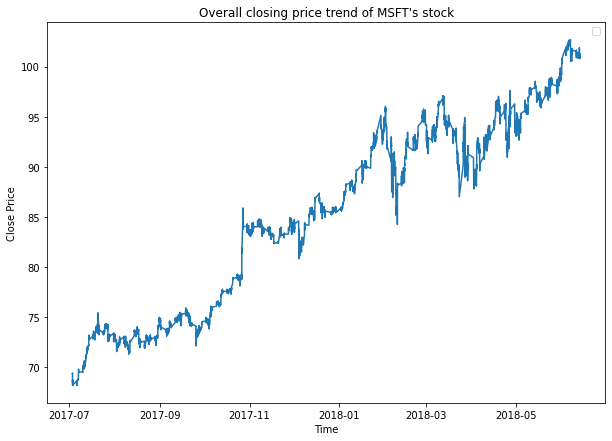

In [8]:
plt.figure(figsize=(10,7))
plt.plot(df['Date'],df['Close'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Overall closing price trend of {}\'s stock'.format(stock))
plt.legend()

### 3.1 Ridge Regression

This is particularly useful to mitigate the problem of multicollinearity in linear regression, which commonly occurs in models with large numbers of parameters. However, in our data,  the number of parameters is not large so ridge regression with one predictor would not be so desired to be used.

In [56]:
#######################
#
#
#   Using price data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

ridge_model_pr = Ridge(random_state=100)
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1]
}

ridge_model_pr_cv = GridSearchCV(ridge_model_pr, param_grid=param_grid, cv=5)
ridge_model_pr_cv.fit(x_train,y_train)

ridge_model_pr = ridge_model_pr.set_params(**ridge_model_pr_cv.best_params_)
ridge_model_pr.fit(x_train,y_train)

df['Future_pch_predicted_Ridge_pr'] = ridge_model_pr.predict(x_data)
df['Future_pred_Ridge_pr'] = df['Future_pch_predicted_Ridge_pr'] * df['Close'] + df['Close']

In [38]:
#######################
#
#
#   Using price&news data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch', 'Senti']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

ridge_model_both = Ridge(random_state=100)
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1]
}

ridge_model_both_cv = GridSearchCV(ridge_model_both, param_grid=param_grid, cv=5)
ridge_model_both_cv.fit(x_train,y_train)

ridge_model_both = ridge_model_both.set_params(**ridge_model_both_cv.best_params_)
ridge_model_both.fit(x_train,y_train)

df['Future_pch_predicted_Ridge_both'] = ridge_model_both.predict(x_data)
df['Future_pred_Ridge_both'] = df['Future_pch_predicted_Ridge_both'] * df['Close'] + df['Close']

Mean squared error for future price using price data: 0.06771142284611628
True     1425
False      78
dtype: int64
Mean squared error for future price using price&news data: 0.06770674204632066
True     1425
False      78
dtype: int64


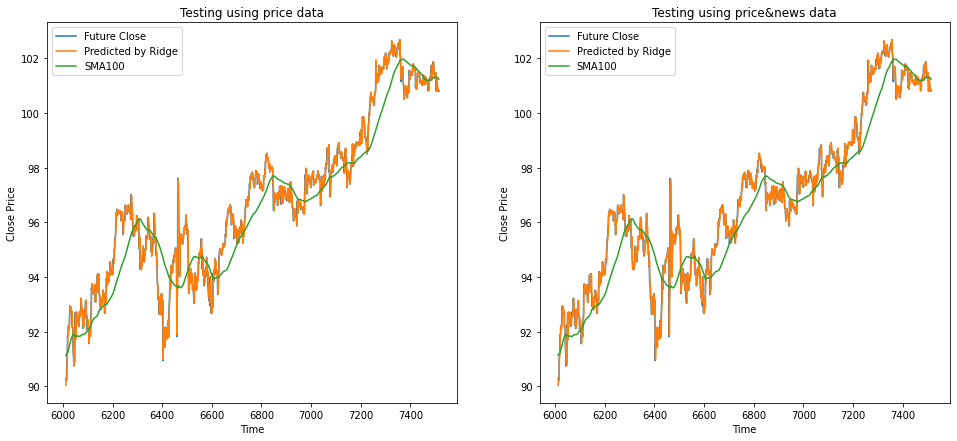

In [57]:
threshold = .5

print('Mean squared error for future price using price data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_Ridge_pr'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_Ridge_pr'][split_time:-1]) < threshold).value_counts())
print('Mean squared error for future price using price&news data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_Ridge_both'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_Ridge_both'][split_time:-1]) < threshold).value_counts())

plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
# plt.figure(figsize=(8,5))
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_Ridge_pr'][split_time:], label = 'Predicted by Ridge')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price data')
plt.legend()

plt.subplot(1,3,2)
# plt.figure(figsize=(8,5))
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_Ridge_both'][split_time:], label = 'Predicted by Ridge')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price&news data')
plt.legend()

All the graphs plotted show the expected price at a low level of errors given using different set of data(i.e. price and price&news). The MSE is calculated to be relatively low and the True/False table indicates the number of observation thatt the expected price will be within an error of .5. Overall for about 94.8% of the time, this model predicts a price within a $.5 of error.

### 3.2 Random Forest

When the price is not observed in the training data but in the testing data, the predicted price would be not correct. Therefore, the percent increase for each feature is considered to calcuate the future price percent increase and then finalize it with the predicted future price for this model. With the gridsearch 5-split cross-validation random forest regressor, 400 estimators are used to predict.



In [4]:
#######################
#
#
#   Using price data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

rf_model_pr = RandomForestRegressor(random_state=100)
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model_pr_cv = GridSearchCV(rf_model_pr, param_grid=param_grid, cv=5)
rf_model_pr_cv.fit(x_train,y_train)
# print(rf_model_pr_cv.best_params_)
# print(rf_model_pr_cv.best_score_)

rf_model_pr = rf_model_pr.set_params(**rf_model_pr_cv.best_params_)
rf_model_pr.fit(x_train,y_train)

df['Future_pch_predicted_RF_pr'] = rf_model_pr.predict(x_data)
df['Future_pred_RF_pr'] = df['Future_pch_predicted_RF_pr'] * df['Close'] + df['Close']

In [6]:
#######################
#
#
#   Using news data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df['Senti'], dtype=int).reshape(-1,1)
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

rf_model_news = RandomForestRegressor(max_features = 1, oob_score = True, min_samples_leaf = 4, random_state=100)
param_grid = {
    'n_estimators': [100, 200, 400]
}
rf_model_news_cv = GridSearchCV(rf_model_news, param_grid=param_grid, cv=5)
rf_model_news_cv.fit(x_train,y_train)
# print(rf_model_news_cv.best_params_)
# print(rf_model_news_cv.best_score_)

rf_model_news = rf_model_news.set_params(**rf_model_news_cv.best_params_)
rf_model_news.fit(x_train,y_train)

df['Future_pch_predicted_RF_news'] = rf_model_news.predict(x_data)
df['Future_pred_RF_news'] = df['Future_pch_predicted_RF_news'] * df['Close'] + df['Close']

In [7]:
#######################
#
#
#   Using price&news data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch', 'Senti']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

rf_model_both = RandomForestRegressor(random_state=100)
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_model_both_cv = GridSearchCV(rf_model_both, param_grid=param_grid, cv=5)
rf_model_both_cv.fit(x_train,y_train)
# print(rf_model_both_cv.best_params_)
# print(rf_model_both_cv.best_score_)

rf_model_both = rf_model_both.set_params(**rf_model_both_cv.best_params_)
rf_model_both.fit(x_train,y_train)

df['Future_pch_predicted_RF_both'] = rf_model_both.predict(x_data)
df['Future_pred_RF_both'] = df['Future_pch_predicted_RF_both'] * df['Close'] + df['Close']

Mean squared error for future price using price data: 0.07012419854997234
True     1427
False      76
dtype: int64
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Mean squared error for future price using news data: 0.06795345570784567
True     1422
False      81
dtype: int64
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Mean squared error for future price using price&news data: 0.06955547601603145
True     1425
False      78
dtype: int64


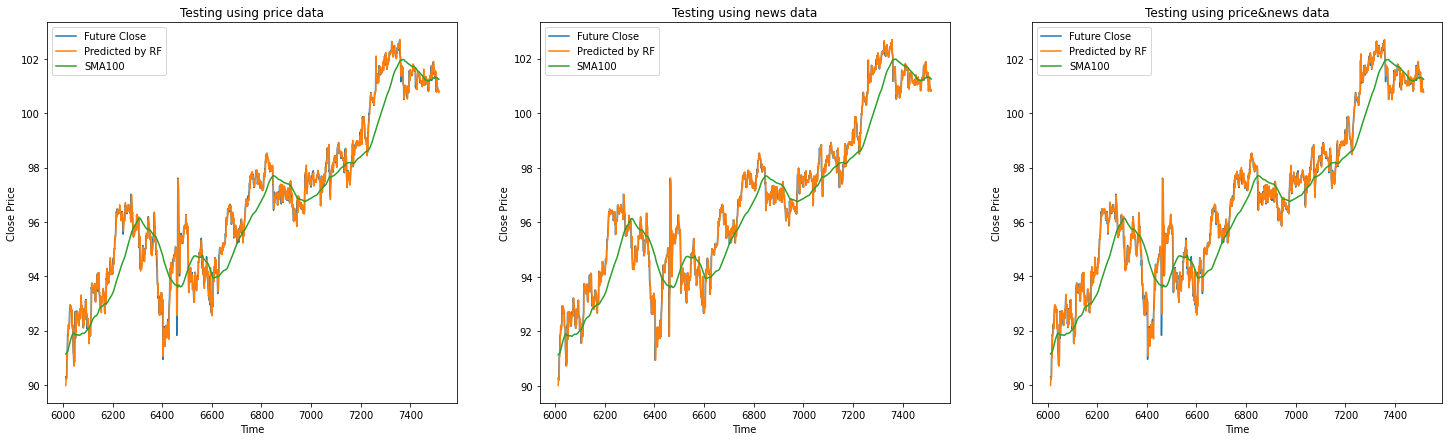

In [9]:
threshold = .5

print('Mean squared error for future price using price data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_RF_pr'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_RF_pr'][split_time:-1]) < threshold).value_counts())
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Mean squared error for future price using news data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_RF_news'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_RF_news'][split_time:-1]) < threshold).value_counts())
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Mean squared error for future price using price&news data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_RF_both'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_RF_both'][split_time:-1]) < threshold).value_counts())

plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
# plt.figure(figsize=(8,5))
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_RF_pr'][split_time:], label = 'Predicted by RF')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price data')
plt.legend()

plt.subplot(1,3,2)
# plt.figure(figsize=(8,5))
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_RF_news'][split_time:], label = 'Predicted by RF')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using news data')
plt.legend()

plt.subplot(1,3,3)
# plt.figure(figsize=(8,5))
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_RF_both'][split_time:], label = 'Predicted by RF')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price&news data')
plt.legend()

All the graphs plotted show the expected price at a low level of errors given using different set of data(i.e. price, news, and price&news). The Mean Square Error(MSE) is calculated to show the metric and the True/False table indicates the number of observation thatt the expected price will be within an error of .5. Overall for about 94.8% of the time, this model predicts a price within a $.5 of error.

### 3.3 Support Vector Machine

In [10]:
#######################
#
#
#   Using price data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

svr_model_pr = SVR()
param_grid = {
    'C': [.0001, .001, .01, 0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly']
}
svr_model_pr_cv = GridSearchCV(svr_model_pr, param_grid=param_grid, cv=5)
svr_model_pr_cv.fit(x_train,y_train)
# print(svr_model_pr_cv.best_params_)
# print(svr_model_pr_cv.best_score_)

svr_model_pr = svr_model_pr.set_params(**svr_model_pr_cv.best_params_)
svr_model_pr.fit(x_train,y_train)

df['Future_pch_predicted_SVR_pr'] = svr_model_pr.predict(x_data)
df['Future_pred_SVR_pr'] = df['Future_pch_predicted_SVR_pr'] * df['Close'] + df['Close']

In [11]:
#######################
#
#
#   Using news data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df['Senti'], dtype=int).reshape(-1,1)
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

svr_model_news = SVR()
param_grid = {
    'C': [.0001, .001, .01, 0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly']
}
svr_model_news_cv = GridSearchCV(svr_model_news, param_grid=param_grid, cv=5)
svr_model_news_cv.fit(x_train,y_train)
# print(svr_model_pr_cv.best_params_)
# print(svr_model_pr_cv.best_score_)

svr_model_news = svr_model_news.set_params(**svr_model_news_cv.best_params_)
svr_model_news.fit(x_train,y_train)

df['Future_pch_predicted_SVR_news'] = svr_model_news.predict(x_data)
df['Future_pred_SVR_news'] = df['Future_pch_predicted_SVR_news'] * df['Close'] + df['Close']

In [ ]:
#######################
#
#
#   Using price&news data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch', 'Senti']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]


svr_model_both = SVR()
param_grid = {
    'C': [.0001, .001, .01, 0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly']
}
svr_model_both_cv = GridSearchCV(svr_model_both, param_grid=param_grid, cv=5)
svr_model_both_cv.fit(x_train,y_train)
# print(svr_model_both_cv.best_params_)
# print(svr_model_both_cv.best_score_)

svr_model_both = svr_model_both.set_params(**svr_model_both_cv.best_params_)
svr_model_both.fit(x_train,y_train)

df['Future_pch_predicted_SVR_both'] = svr_model_both.predict(x_data)
df['Future_pred_SVR_both'] = df['Future_pch_predicted_SVR_both'] * df['Close'] + df['Close']

Mean squared error for future price using price data: 0.2585091324950895
True     988
False    515
dtype: int64
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Mean squared error for future price using news data: 0.2585091324950895
True     988
False    515
dtype: int64
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Mean squared error for future price using price&news data: 0.2585091324950895
True     988
False    515
dtype: int64


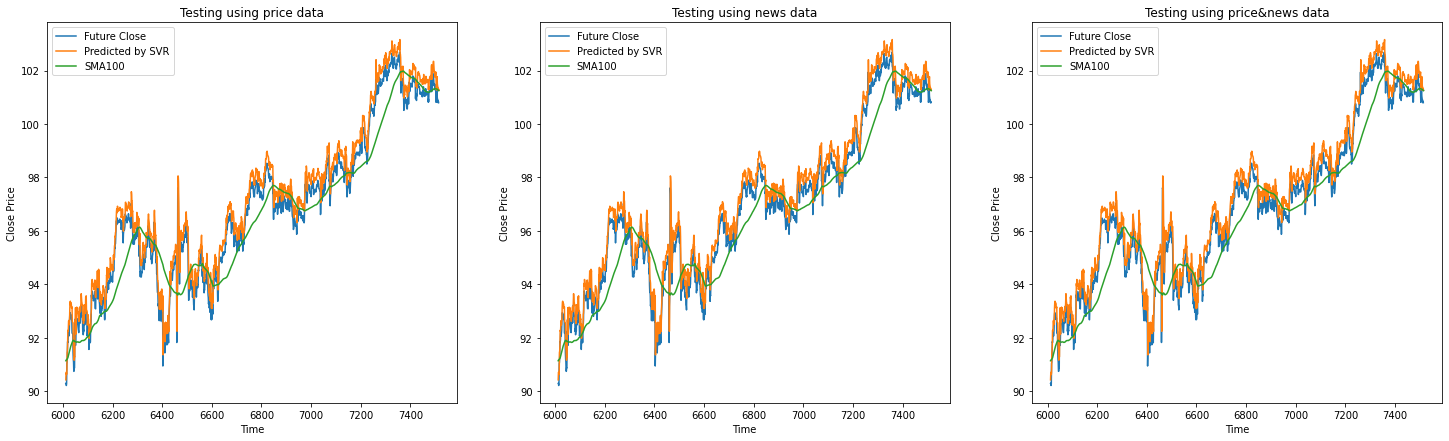

In [13]:
threshold = .5
print('Mean squared error for future price using price data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_SVR_pr'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_SVR_pr'][split_time:-1]) < threshold).value_counts())
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Mean squared error for future price using news data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_SVR_news'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_SVR_news'][split_time:-1]) < threshold).value_counts())
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Mean squared error for future price using price&news data: {}'.format(mean_squared_error(df['Future'].to_numpy()[split_time:-1],df['Future_pred_SVR_both'].to_numpy()[split_time:-1])))
print(pd.Series(abs(df['Future'][split_time:-1] - df['Future_pred_SVR_both'][split_time:-1]) < threshold).value_counts())

plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_SVR_pr'][split_time:], label = 'Predicted by SVR')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price data')
plt.legend()

plt.subplot(1,3,2)
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_SVR_news'][split_time:], label = 'Predicted by SVR')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using news data')
plt.legend()

plt.subplot(1,3,3)
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_SVR_both'][split_time:], label = 'Predicted by SVR')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price&news data')
plt.legend()

Likewise these graphs plotted above show the expected price at a low level of errors given using different set of data(i.e. price, news, and price&news). However, this model generates a littl higher value than a true value overall, which leads to a higher level of errors compared to the RF or Ridge model. The True/False table also shows that the number of observations that fall outside the range of \$.5 is greater so one can conclude that for only about 65.7\% of the time, this model predicts a price within a \$.5 of error.

### 3.4 Neural Network

#### 3.4.1 Deep Neural Network

A closing price will be predicted for a deep neural network model and compared with 100-day simple moving average(SMA) for their efficiencies.

For the structure of Deep Neural Network, it is composed by three layers with 128, 64, and 32 neurons respectively, applying the LeakyReLU acitivation for each layer in which a batch normalization was inserted to aviod the covariate shift. Also, Dropout rate of .5 is applied in order to avoid overfitting and improve the generalization power of the network. The Adam optimizer is used to minimize the mean squared error function with learning rate of .01.

$$ L(x) = {1 \over n}\sum\limits_{x=1}^{\infty} {(Y_i - \hat{Y_i})^2}$$

A hundred epochs are used to train the model and the followings are the results.


In [14]:
#######################
#
#
#   Using price data
#
#
#######################
y_data = np.array(df['Future_pch'])
x_data = np.array(df[['Open_pch', 'High_pch', 'Low_pch', 'Close_pch', 'Volume_pch']])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

tf.random.set_seed(1000)
lr = 1e-2
l2_reg = .01
max_value = 1
batch_size = 100
training_epochs = 100
drop_rate = .5
Ne = 128

dnn_model_pr = tf.keras.Sequential([
  tf.keras.layers.Dense(Ne, input_shape=(x_train.shape[1:]), activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(Ne/2, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(Ne/4, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')
])

dnn_model_pr.compile(loss= 'mse',
              optimizer=tf.keras.optimizers.Adam(lr=lr))
dnn_model_pr.summary()

dnn_history_pr = dnn_model_pr.fit(x_train, y_train,
  batch_size=batch_size,
  verbose = 0,
  epochs=training_epochs,
  validation_data=(x_valid,y_valid)
)  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

Mean squared error for future price using price data: 0.0680053534379009
True     1422
False      81
dtype: int64


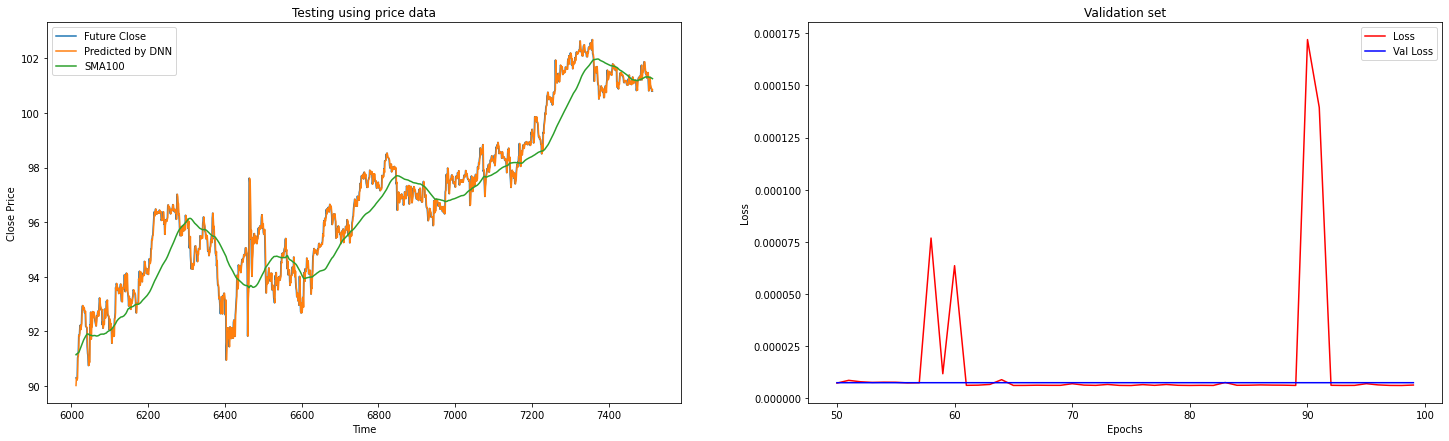

In [15]:
threshold = .5
dnn_predicted_pr = dnn_model_pr.predict(x_valid) * df['Close'][split_time:].to_numpy().reshape(-1,1) + df['Close'][split_time:].to_numpy().reshape(-1,1)
print('Mean squared error for future price using price data: {}'.format(mean_squared_error(df['Future'][split_time:-1].to_numpy().reshape(-1,1), dnn_predicted_pr[:-1])))
print(pd.Series(abs(df['Future'][split_time:-1].to_numpy() - dnn_predicted_pr[:-1].reshape(-1)) < threshold).value_counts())

plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
plt.plot(df['Future'][split_time:-1], label = 'Future Close')
plt.plot(df.index[split_time:-1], dnn_predicted_pr[:-1], label = 'Predicted by DNN')
plt.plot(df['SMA100'][split_time:-1], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price data')
plt.legend()

loss=dnn_history_pr.history['loss']
val_loss=dnn_history_pr.history['val_loss']
epochs=range(len(loss))

plt.subplot(1,2,2)
plt.plot(epochs[50:], loss[50:], 'r', label = 'Loss')
plt.plot(epochs[50:], val_loss[50:], 'b', label = 'Val Loss')
plt.title('Validation set')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


The DNN also shows the expected price at a low level of errors using price data. The MSE is about .06 and the True/False table indicates that the expected price will be within an error of .5 for about 94.6% of the time. The loss plot on the right gets smaller as the epoch is increasing.

####  3.4.2. Recurrent Neural Network

From here, let's take a little different path for data manipulation. We've been trying to predict the future closing price with a set of prices from previous time period and corresponding news data. However, I'd like to use only closing price to predict the next closing price. So, previous 100 closing prices is set to one window to estimate the next price and the window of prices steps down as the future closing price gets further. For every stock, 80% of the prices are trained and the rest will be tested for validating its model performance.

For the structure of Recurrent Neural Network, it is composed by two RNN layers with 50 neurons each applying the relu acitivation. The stochastic gradient descent optimizer is exploited to minimize the Huber loss function;

20 epochs are used to train the model and the followings are the results.

$$L_{\delta}(a) =
\left\{
    \begin{array}{ll}
        {1 \over 2}a^2  & \mbox{for } |a| \le \delta, \\
        \delta(|a|-{1 \over 2}\delta) & \mbox{otherwise }
    \end{array}
\right.$$



In [33]:
time = df.index.values
series = df['Close'].values
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 300
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(False)


# plt.figure(figsize=(10,6))
# plot_series(time,series)
# plt.title("{}'s stock".format(df['Symbol'][1]))

(1e-07, 0.0001, 0.0, 60.0)

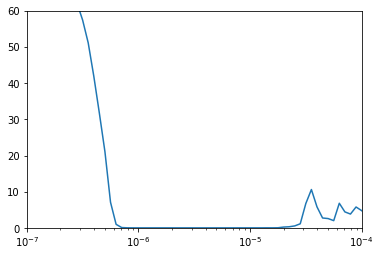

In [17]:
tf.random.set_seed(1000)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu'),
  tf.keras.layers.SimpleRNN(50, activation='relu'),
  tf.keras.layers.Dense(1)#,
  # tf.keras.layers.Lambda(lambda x: x * 100.0) # act func: tan h from -1 to 1 so implemented
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0, validation_data=(x_valid,y_valid))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7,1e-4,0,60])

In [18]:
tf.random.set_seed(1000)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

rnn_model_pr = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu'),
  tf.keras.layers.SimpleRNN(50, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
rnn_model_pr.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
rnn_history_pr = rnn_model_pr.fit(dataset, epochs=50, verbose=0, validation_data=(x_valid,y_valid))

In [31]:
rnn_forecast_pr = []
for time in range(len(df) - window_size):
    rnn_forecast_pr.append(rnn_model_pr.predict(series[time:time + window_size][np.newaxis]))

rnn_forecast_pr = rnn_forecast_pr[split_time-window_size:]
rnn_results_pr = np.array(rnn_forecast_pr)[:, 0, 0]

Mean squared error for future price using price data: 0.1274606672799516
True     1341
False     163
dtype: int64


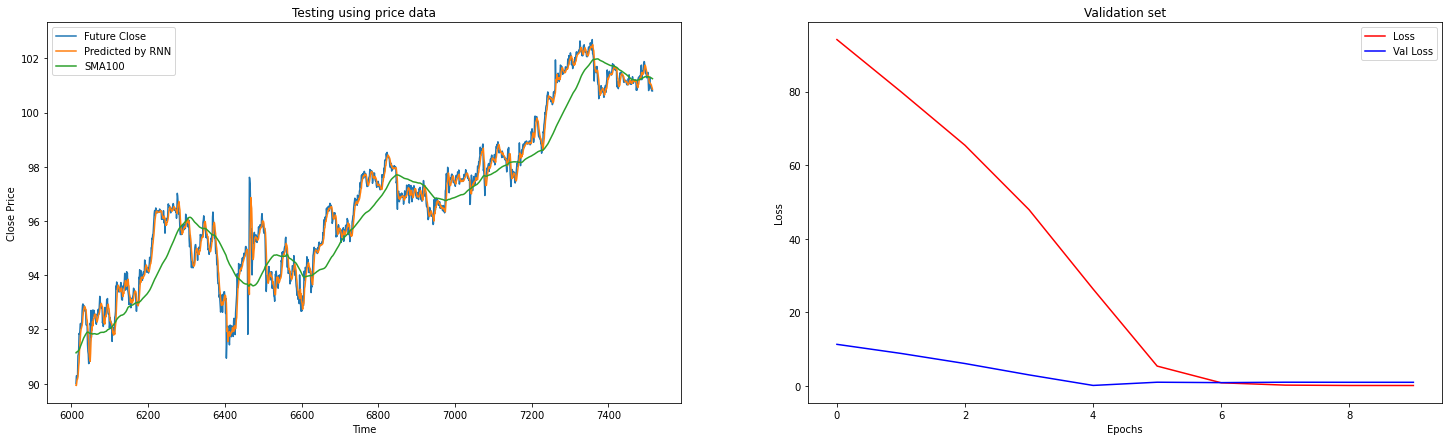

In [36]:
threshold = .5
print('Mean squared error for future price using price data: {}'.format(mean_squared_error(x_valid,rnn_results_pr)))
print(pd.Series(abs(x_valid - rnn_results_pr) < threshold).value_counts())

plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
plt.plot(time_valid, x_valid, label = 'Future Close')
plt.plot(time_valid, rnn_results_pr, label = 'Predicted by RNN')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing using price data')
plt.legend()

loss=rnn_history_pr.history['loss']
val_loss=rnn_history_pr.history['val_loss']
epochs=range(len(loss))

plt.subplot(1,2,2)
plt.plot(epochs[:10], loss[:10], 'r', label = 'Loss')
plt.plot(epochs[:10], val_loss[:10], 'b', label = 'Val Loss')
plt.title('Validation set')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

The RNN produces the expected price at a low level of errors using price data. The MSE is about .127 and the True/False table indicates that the expected price will be within an error of .5 for about 89% of the time. The loss plot on the right stop getting smaller after 6 epochs, which means that the model doesn't learm after 6 epoch much so the structure or parameters needs to be tuned.

## 4. Closing

Overall, those five Machine Learning algorithms have been developed and corresponding metrics are calculated to help to decide which algorithm to use.

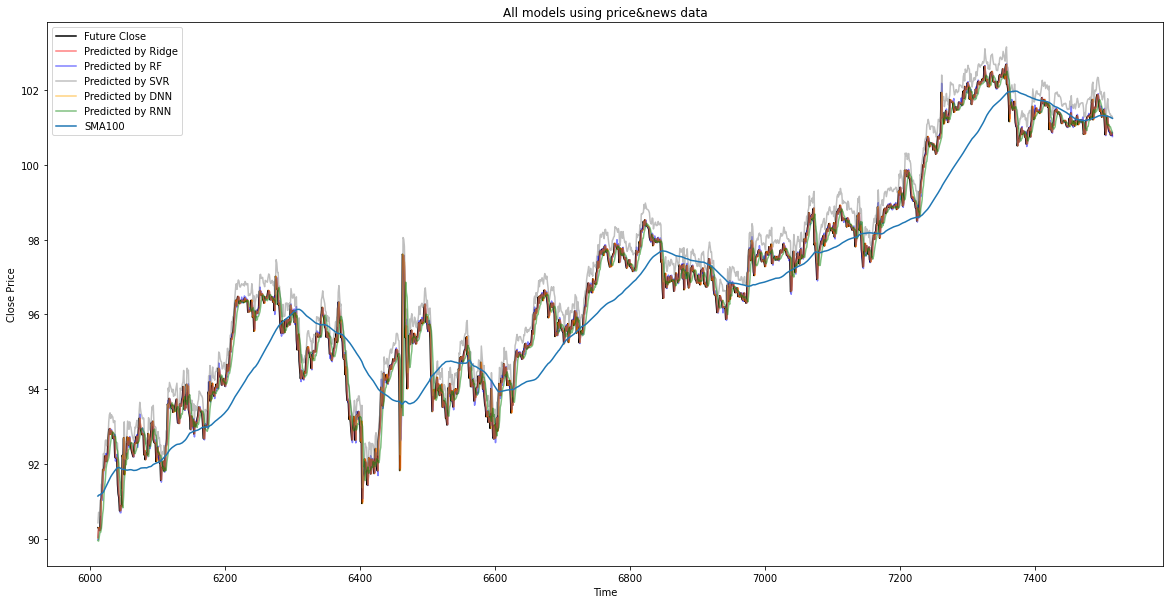

In [64]:
plt.figure(figsize=(20,10))
plt.plot(df['Future'][split_time:], label = 'Future Close', color = 'black')
plt.plot(df['Future_pred_Ridge_both'][split_time:], label = 'Predicted by Ridge', alpha=.5, color = 'r')
plt.plot(df['Future_pred_RF_both'][split_time:], label = 'Predicted by RF', alpha=.5, color = 'b')
plt.plot(df['Future_pred_SVR_both'][split_time:], label = 'Predicted by SVR', alpha=.5, color = 'grey')
plt.plot(df.index[split_time:-1], dnn_predicted_pr[:-1], label = 'Predicted by DNN', alpha=.5, color = 'orange')
plt.plot(time_valid, rnn_results_pr, label = 'Predicted by RNN', alpha=.5, color = 'g')
plt.plot(df['SMA100'][split_time:], label = 'SMA100')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('All models using price&news data')
plt.legend()
